# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [101]:
# imports
import pyaudio
import wave
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders
import json
from urllib.request import urlopen
from word2number import w2n
import houndify
import aifc
import soundfile as sf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# import houndify and email params
# these files contain user specific information and thus need to be created by each use
import houndify_login as lg
import mail_params as mp

In [102]:
# create function to do record audio command and save as a wav file in format req'd for houndify
def rec_audio(fl_name):
    
    # initialize params for pyaudio
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    
    # set up recording
    print('Welcome to Monty!\n')
    print('Please give me a request (type "ii" when done)')
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    
    # record until keyboard is used to stop recording
    try:
        while True:
            data = stream.read(chunk)
            all.append(data)
    except KeyboardInterrupt:
        pass
    
    # close down recording
    print('Processing request...\n')
    stream.close()
    p.terminate()
    
    # write to .wav file
    data = b"".join(all)
    wf = wave.open(fl_name, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [103]:
# given a wav audio file, use houndify to return a list of all words spoken (in order) from audio file
def audio_to_text(wav_fl, ID, KEY):
    
    # open audio file
    audio = wave.open(wav_fl)
    
    # make sure audio file is in the correct format
    if audio.getsampwidth() != 2:
        print("wrong sample width (must be 16-bit)")
    if audio.getframerate() != 8000 and audio.getframerate() != 16000:
        print("unsupported sampling frequency (must be either 8 or 16 khz)")
    if audio.getnchannels() != 1:
        print("must be single channel (mono)")

    # connect to houndify and use it to perform audio to text conversion
    client = houndify.StreamingHoundClient(ID, KEY, "test_user")
    client.setSampleRate(audio.getframerate())
    client.start()
    while True:
        samples = audio.readframes(1024)
        if len(samples) == 0: break
        if client.fill(samples): break
    result = client.finish()
    
    # return a list of all words in audio file (in order)
    return result['AllResults'][0]['RawTranscription'].split(' ')

In [104]:
# function to take a raw request (from audio_to_text) and extract subject and body
def proc_for_email(request):
    
    # the subject of the email will be all the words in the list after 'subject' and before the 'and' before 'body' 
    subj = request[request.index('subject')+1:request.index('body')-1]
    
    # body of the email will be all the words after 'body'
    body = request[request.index('body')+1:]
    
    # return the subject and body of the message by joining each list subset into a string
    return ' '.join(subj), ' '.join(body)

In [105]:
# given sending address + password, to address, subject, and body, send email
# NB: this implementation requires one to set their Gmail account to accept "less secure apps"
#    https://myaccount.google.com/u/4/lesssecureapps
def send_email(sender, pwd, to, subject, body):
    
    # setup message attributes
    msg = MIMEMultipart()
    msg["From"] = sender
    msg["To"] = to # one sender only
    #msg["Date"] = formatdate(localtime=True)
    msg["Subject"] = subject
    msg.attach(MIMEText(body))
    
    # send message
    mailServer = smtplib.SMTP("smtp.gmail.com", 587)
    mailServer.ehlo()
    mailServer.starttls()
    mailServer.login(sender, pwd)
    mailServer.sendmail(sender, to, msg.as_string())
    mailServer.close()

In [115]:
# obtain a random joke from the internet chuck norris database
def pull_joke(url = 'http://api.icndb.com/jokes/random'):
    
    # query the internet database and store result as json
    result = json.loads(urlopen(url).read().decode("UTF-8"))
    
    # print the joke (replacing html quotes with printed quotes)
    print(result['value']['joke'].replace('&quot;','"'))

In [116]:
# take words containing a mathematical expression and evaluate the expression
def math_from_words(request):
    
    # while I could imagine writing a function with a large dictionary to parse numbers as words into integers
    #    or floats, this would be somewhat cumbersome - especially when there is a nice python package that does it.
    #    I will use the 
    
    # create dictionary of mathematical symbols to interpret
    symbols = {'plus': '+', 'minus': '-', 'times': '*', 'divided': '/'}
    
    # create a new list to hold items from the request that are part of the mathematical expression
    expr_list = []
    
    # create an empty string to hold sequential words that correspond to one number
    expr = ''
    
    # iterate through the request and extract items that are part of the expression
    for idx, word in enumerate(request):
        
        # check to see if the word is a symbol, if so add it
        if word in symbols.keys():
            
            # if the word is symbol write the current number expression to the list and re-initialize an empty one
            # the rational here is that symbols separate sequences of words that represent a single number
            expr_list.append(expr)
            expr = ''
            
            # if 'divided' is the word, require that it be followed by 'by' to count as symbol
            if word != 'divided':
                expr_list.append(symbols[word])
            elif word == 'divided' and request[idx +1] == 'by':
                expr_list.append(symbols[word])
            
        # if the word isn't a symbol, check to see if it is the number 4, but spelled as 'for' - if so include it
        elif word == 'for':
            expr += ' four'
            
        # if the word is 'point', set it up to be interpreted as a decimal point
        elif word == 'point':
            expr += ' point'
        
        # if the word doesn't meet the above conditions it should either be a number or an irrelevant word
        #     it will be an irrelevant word if the function throws a value error - catch and handle this
        #     if there is not a value error, then it is a number - include it
        else:
            try:
                tmp = str(w2n.word_to_num(word))
                expr += ' ' + word
            except ValueError:
                pass
    
    # add the last sequence of numbers to the expression list - the conditions make it possible for there to be
    #     a non-empty sequence stored when iteration ends
    expr_list.append(expr)
    
    # initialize an expression to evaluate
    expr_to_eval = ''
    
    # iterate through the list holding the mathematical expression
    for item in expr_list:
        
        # if the current item is a symbol, add it to the expression to evaluate
        if item in symbols.values():
            expr_to_eval += item
        
        # otherwise the current item is a sequence corresponding to one number - convert this from words to a number
        else:
            expr_to_eval += str(w2n.word_to_num(item))
    
    # evaluate the mathematical expression and print the result
    print('{} = {}'.format(expr_to_eval, eval(expr_to_eval)))

In [117]:
# function that completely controls and runs monty
def monty(ID, KEY, fl_name = 'tmp_audio/tmp.wav', print_req = False):
    
    # record audio and store it as a wav file
    rec_audio(fl_name)
    
    # get a list of words (in order) from the audio file
    request = audio_to_text(fl_name, ID, KEY)
    
    # optionally print the text obtained from audio
    if print_req:
        print(request)
    
    # determine what to do
    
    # if no words were registered, let the user know
    if len(request) == 1:
        print("Sorry, I didn't get that. Please try again.")
    
    # detect an email request by having the words 'email', 'subject', and 'body' all appear in request
    elif set(('email','subject','body')).issubset(set(request)):
        subject, body = proc_for_email(request)
        send_email(mp.sender, mp.pwd, mp.sender, subject, body)
        print('email sent!')
        
    # detect a joke request by having the words 'tell' and 'joke' in request and having request not be an email
    elif set(('tell','joke')).issubset(set(request)):
        pull_joke()
        
    # if it isn't an email or joke request, assume it is a math request
    else:
        math_from_words(request)

In [120]:
monty(lg.ID, lg.KEY)

Welcome to Monty!

Please give me a request (type "ii" when done)
Processing request...

Chuck Norris doesn't need sudo, he just types "Chuck Norris" before his commands.


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [85]:
# note: I adapted the below variables and function to convert frequencies to musical notes
#     source: https://www.johndcook.com/blog/2016/02/10/musical-pitch-notation/

A4 = 440
C0 = A4*2**-4.75
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    h = round(12*np.log2(freq/C0))
    octave = int(h // 12)
    n = int(h % 12)
    return name[n] + str(octave)

In [86]:
# identify if a given frequency is a harmonic of a reference frequency
def is_harmonic(freq, ref_freq, tol=0.05):

    # harmonics are integer multiples of a reference frequency, so check the first ten integer multiples
    # also allow for fractional error of fol - if any are within tolerance consider it a harmonic
    harmonics = ref_freq*np.arange(2,11,1)
    rh = False
    for hh in harmonics:
        if np.abs(1 - hh/freq) < tol:
            rh = True
            
    return rh

In [98]:
# given a stereo aiff file as input, plot the frequency power spectrum on a suplied axis and identify musical notes
def note_ID(fl, note_thresh = 0.25, ax_idx = 0):
    
    # read in file
    data, fs = sf.read(fl, dtype = 'int32')
    
    # convert stereo data to mono by summing
    data_full = data.sum(axis=-1)
    
    # obtain frequencies and frequency power spectrum
    N = len(data_full)
    freqs = np.fft.rfftfreq(N, d = 1/fs)
    pow_spec = np.abs(np.fft.rfft(data_full))**2
    
    # find frequencies that correspond to peaks above the threshold (percentage of maximum value)
    fp = freqs[pow_spec > note_thresh*np.max(pow_spec)]
    
    # identify the unique notes that correspond to these frequencies and exclude harmonics
    freq_list = [fp[0]] # start with frequency identified as corresponding to a maximum
    notes = [pitch(freq_list[0])]
    for ff in fp:
        if pitch(ff) not in notes:
            if is_harmonic(ff, freq_list[0]) is False:
                notes.append(pitch(ff))
                freq_list.append(ff)
            else:
                pass

    # make plot
    ax[ax_idx].semilogx(freqs, pow_spec)
    ax[ax_idx].axhline(note_thresh * np.max(pow_spec), color = 'black', linestyle = 'dashed')
    ax[ax_idx].set_xlabel('Frequency (Hz)')
    ax[ax_idx].set_ylabel('Power Spectrum')
    ax[ax_idx].set_title('Notes Identified in {}: {}'.format(fl.split('/')[-1], ', '.join(notes)))
        
    return notes

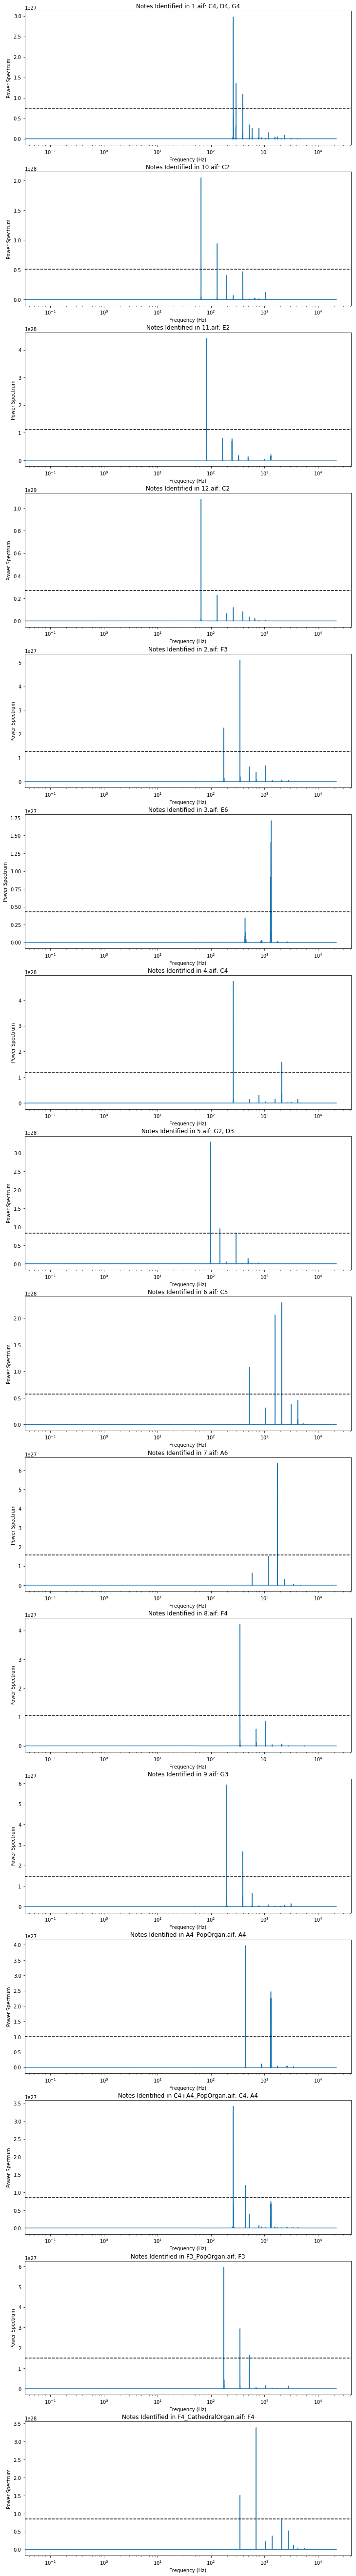

In [99]:
# load in audio file names
aud_files = sorted([fl for fl in os.listdir('sound_files/') if '.aif'])

fig, ax = plt.subplots(len(aud_files), 1, figsize = (12, 6*len(aud_files)))

# iterate through file names and determine notes
results = []
for idx, fl in enumerate(aud_files):
    
    nts = note_ID('sound_files/' + fl, ax_idx = idx)
    results.append([fl, nts])

In [100]:
# print final results
for row in results:
    print('Notes identified in file {}: {}'.format(row[0], ', '.join(row[1])))

Notes identified in file 1.aif: C4, D4, G4
Notes identified in file 10.aif: C2
Notes identified in file 11.aif: E2
Notes identified in file 12.aif: C2
Notes identified in file 2.aif: F3
Notes identified in file 3.aif: E6
Notes identified in file 4.aif: C4
Notes identified in file 5.aif: G2, D3
Notes identified in file 6.aif: C5
Notes identified in file 7.aif: A6
Notes identified in file 8.aif: F4
Notes identified in file 9.aif: G3
Notes identified in file A4_PopOrgan.aif: A4
Notes identified in file C4+A4_PopOrgan.aif: C4, A4
Notes identified in file F3_PopOrgan.aif: F3
Notes identified in file F4_CathedralOrgan.aif: F4
